# Imports and prep

In [3]:
#fix for newer versions of pandas. Shipped version is not supported
!apt remove python3-xlrd
!apt remove python-xlrd
!pip uninstall -y xlrd
!pip install xlrd==1.2.0
!pip install pyngrok
!apt install php

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package 'python3-xlrd' is not installed, so not removed
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package 'python-xlrd' is not installed, so not removed
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Found existing installation: xlrd 1.2.0
Uninstalling xlrd-1.2.0:
  Successfully uninstalled xlrd-1.2.0
  Using cached xlrd-1.2.0-py2.py3-none-any.whl (103 kB)


In [4]:
#basic imports - primarily preprocessing, datamanipulation and visualisation
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import datetime
import time
import re
from sklearn.preprocessing import MinMaxScaler

#for training 
import tensorflow as tf
import keras
from keras import optimizers
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, Input, Activation
from keras.callbacks import EarlyStopping

In [5]:
# All our files ~are~ were on drive
# from google.colab import drive
# drive.mount('/content/gdrive')
# s_data = "/content/gdrive/MyDrive/project/s-data/*"
# !cp -r $s_data /content/

In [6]:
!git clone https://github.com/paragdhankhart1dm/t1dmProject
!cp t1dmProject/data/* /content/

Cloning into 't1dmProject'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 41 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (41/41), done.


# File selection

In [7]:
files = os.listdir('/content/')
removes = []
for x in range(0,len(files)):
  if('.xlsx' not in files[x] or 'Patient' not in files[x]):
    removes.append(files[x])
    continue
  print(x+1 - len(removes),files[x])

for f in removes:
  files.remove(f)

# This command is used to build the drop down list in the next cell
# print(files)
# print('--------------------------')
# selected_file = files[int(input("Select a file: "))-1]
# print(selected_file,'was selected')


1 Patient6_Jul2019.xlsx
2 Patient3_Apr2019.xlsx
3 Patient2_Nov2018.xlsx
4 Patient7_Aug2019.xlsx
5 Patient6_Aug2019.xlsx
6 Patient1_Sep2018.xlsx
7 Patient7_Sep2019.xlsx
8 Patient3_Mar2019.xlsx
9 Patient3_Feb2019.xlsx
10 Patient2_Oct2018.xlsx
11 Patient1_Aug2018.xlsx
12 Patient7_Oct2019.xlsx
13 Patient5_Mar2019.xlsx
14 Patient5_Apr2019.xlsx
15 Patient4_Mar2019.xlsx
16 Patient5_May2019.xlsx
17 Patient4_Feb2019.xlsx


In [8]:
#@title Select file, training date, prediction horizon { run: "auto", vertical-output: true, display-mode: "both" }
patient_name = "Divitry Palette" #@param {type:"string"}
gender = "M" #@param ["M", "F", "O"]
selected_file = "Patient4_Feb2019.xlsx" #@param ['Patient7_Aug2019.xlsx', 'Patient1_Sep2018.xlsx', 'Patient6_Aug2019.xlsx', 'Patient5_Apr2019.xlsx', 'Patient5_May2019.xlsx', 'Patient3_Mar2019.xlsx', 'Patient2_Oct2018.xlsx', 'Patient5_Mar2019.xlsx', 'Patient6_Jul2019.xlsx', 'Patient2_Nov2018.xlsx', 'Patient4_Feb2019.xlsx-training-test.txt', 'Patient7_Oct2019.xlsx', 'Patient1_Aug2018.xlsx', 'Patient3_Feb2019.xlsx', 'Patient3_Apr2019.xlsx', 'Patient4_Feb2019.xlsx', 'Patient7_Sep2019.xlsx', 'Patient4_Mar2019.xlsx']
training_start = "2019-02-21" #@param {type:"date"}
training_end = "2019-02-22" #@param {type:"date"}
testing_date = "2019-02-23" #@param {type:"date"}
print(selected_file,'was selected')
print('training dates:', training_start,'to',training_end)
print('testing date:',testing_date)

Patient4_Feb2019.xlsx was selected
training dates: 2019-02-21 to 2019-02-22
testing date: 2019-02-23


# Clean and organize

In [9]:
insulin_sheet = "Step_5"
insulin_data = pd.read_excel(selected_file,sheet_name=insulin_sheet)
print('Insulin data')
print(insulin_data.head())
print(insulin_data.info())

Insulin data
    CGM_DATE APPROX_CGM_TIME Event Type  Glucose Value (mmol/L)     Basal  \
0 2019-02-20        00:00:00        EGV                    13.1  0.079167   
1 2019-02-20        00:05:00        EGV                    13.5  0.079167   
2 2019-02-20        00:10:00        EGV                    13.4  0.079167   
3 2019-02-20        00:15:00        EGV                    13.3  0.079167   
4 2019-02-20        00:20:00        EGV                    13.2  0.079167   

   Bolus  Carbs_gm  Gender  Weight  Height  Baseline HbA1c (mmol/mol)  \
0    0.0         0  Female    69.4     169                         95   
1    0.0         0  Female    69.4     169                         95   
2    0.0         0  Female    69.4     169                         95   
3    0.0         0  Female    69.4     169                         95   
4    0.0         0  Female    69.4     169                         95   

         Age  Duration DM        BMI  WEEKDAY  HOUR  
0  19.476712      7.00274  24.2

In [10]:
training_month = 'Feb2019' #Check the excel file on drive to select
# training_date = ['2019-08-16 00:00:00', '2019-08-17 23:59:59'] #Format - YYYY-MM-DD HH24:MI:SS

#These are set using the form above. Times are default. The time can be changed to experiment in better ranges of data
training_date = [str(training_start)+' 00:00:00', str(training_end)+' 23:59:59'] #Format - YYYY-MM-DD HH24:MI:SS
testing_month = 'Feb2019' #Give testing data month here - refer actual file name for this
# testing_date = ['2019-08-18 00:00:00', '2019-08-18 23:59:59'] #Format - YYYY-MM-DD HH24:MI:SS
testing_date = [str(testing_date)+' 00:00:00', str(testing_date)+' 23:59:59'] #Format - YYYY-MM-DD HH24:MI:SS

bg_unit = 'Glucose Value  mmol/L' #or Glucose Value (mmol/L)
input_properties = [bg_unit, 'Basal', 'Bolus', 'Carbs_gm']

In [11]:
filtered_idata = insulin_data.copy()
filtered_idata['DateTime'] = (str(filtered_idata['CGM_DATE']) + str(' ') + str(filtered_idata['APPROX_CGM_TIME']))
filtered_idata['DateTime'] = pd.to_datetime((filtered_idata['CGM_DATE']).astype(str).str.cat(filtered_idata['APPROX_CGM_TIME'].astype(str),sep=" "))
filtered_idata['DateTime'] = pd.to_datetime(filtered_idata['DateTime'], utc=True) 
filtered_idata['DateTime'] = pd.to_datetime(filtered_idata['DateTime'].dt.tz_localize(None))
# filtered_idata.to_csv('idata-intermediate1.csv')
dropped_features_insulin = ['CGM_DATE','APPROX_CGM_TIME','Event Type','Gender','Weight','WEEKDAY','HOUR','Duration DM','BMI','Height','Baseline HbA1c (mmol/mol)','Age' ]
filtered_idata.drop(dropped_features_insulin,1,inplace=True)
filtered_idata.set_index('DateTime',inplace=True)
filtered_idata['Bolus'].fillna(0,inplace=True)
filtered_idata['Basal'].fillna(0,inplace=True)
filtered_idata['Carbs_gm'].fillna(0,inplace=True)
print(filtered_idata.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2016 entries, 2019-02-20 00:00:00 to 2019-02-26 23:55:00
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Glucose Value (mmol/L)  2016 non-null   float64
 1   Basal                   2016 non-null   float64
 2   Bolus                   2016 non-null   float64
 3   Carbs_gm                2016 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 78.8 KB
None


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


# Some random manual tests

In [12]:
# print(filtered_bgdata)
# print(filtered_bgdata.index.name)
print(filtered_idata)
# filtered_idata.loc[(filtered_idata['Bolus Volume (U)']>0)]
# filtered_idata.loc[(filtered_idata['Basal Amount (U/h)']>0),'Basal Amount (U/h)']
filtered_idata.loc[(filtered_idata['Glucose Value (mmol/L)']>0),'Glucose Value (mmol/L)']

                     Glucose Value (mmol/L)     Basal  Bolus  Carbs_gm
DateTime                                                              
2019-02-20 00:00:00                    13.1  0.079167    0.0         0
2019-02-20 00:05:00                    13.5  0.079167    0.0         0
2019-02-20 00:10:00                    13.4  0.079167    0.0         0
2019-02-20 00:15:00                    13.3  0.079167    0.0         0
2019-02-20 00:20:00                    13.2  0.079167    0.0         0
...                                     ...       ...    ...       ...
2019-02-26 23:35:00                     6.3  0.133333    0.0         0
2019-02-26 23:40:00                     6.4  0.133333    0.0         0
2019-02-26 23:45:00                     6.4  0.133333    0.0         0
2019-02-26 23:50:00                     6.3  0.133333    0.0         0
2019-02-26 23:55:00                     6.3  0.133333    0.0         0

[2016 rows x 4 columns]


DateTime
2019-02-20 00:00:00    13.1
2019-02-20 00:05:00    13.5
2019-02-20 00:10:00    13.4
2019-02-20 00:15:00    13.3
2019-02-20 00:20:00    13.2
                       ... 
2019-02-26 23:35:00     6.3
2019-02-26 23:40:00     6.4
2019-02-26 23:45:00     6.4
2019-02-26 23:50:00     6.3
2019-02-26 23:55:00     6.3
Name: Glucose Value (mmol/L), Length: 2016, dtype: float64

# Visualise

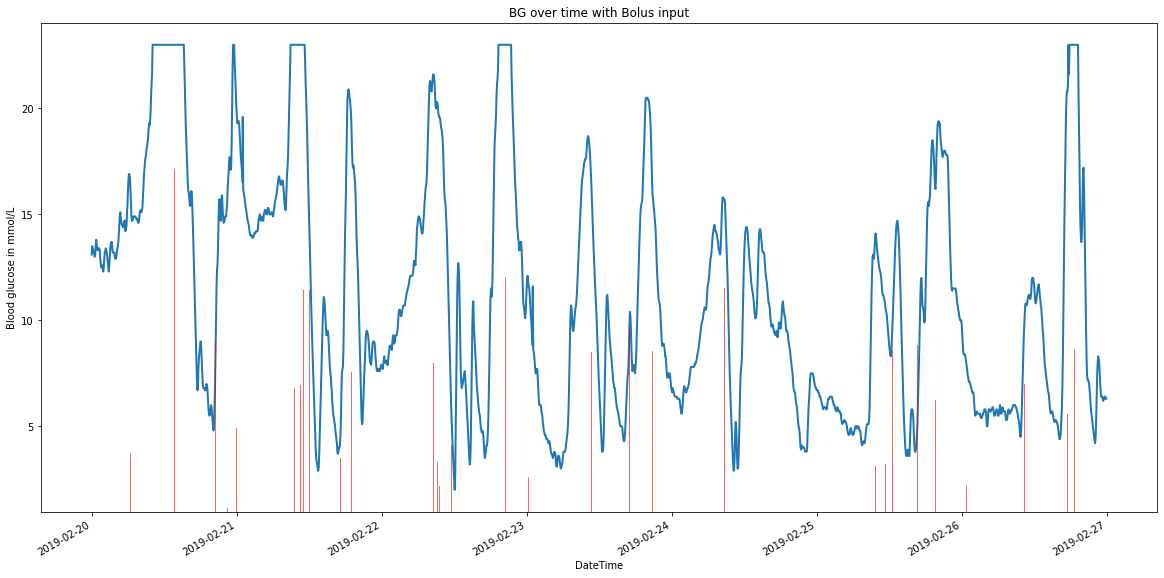

In [13]:
#graph
graph1 = filtered_idata['Glucose Value (mmol/L)'].plot.line(figsize=(20,10),title="BG over time with Bolus input",lw=2,)
graph1.set(xlabel="DateTime",ylabel='Blood glucose in mmol/L')

#bolus intake
max = filtered_idata['Bolus'].max()
for y in filtered_idata.loc[(filtered_idata['Bolus']>0)].index:
  # print(filtered_idata.loc[(filtered_idata.index==y) & (filtered_idata['Bolus Volume (U)']>0),'Bolus Volume (U)'].sum())
  bolus = float(filtered_idata.loc[(filtered_idata.index==y) & (filtered_idata['Bolus']>0),'Bolus'].sum())
  ymax = bolus*0.7/max
  graph1.axvline(x=y,  ymin = 0.0, ymax = ymax, color='#ff000099',lw=1) #remember, transparency at the end



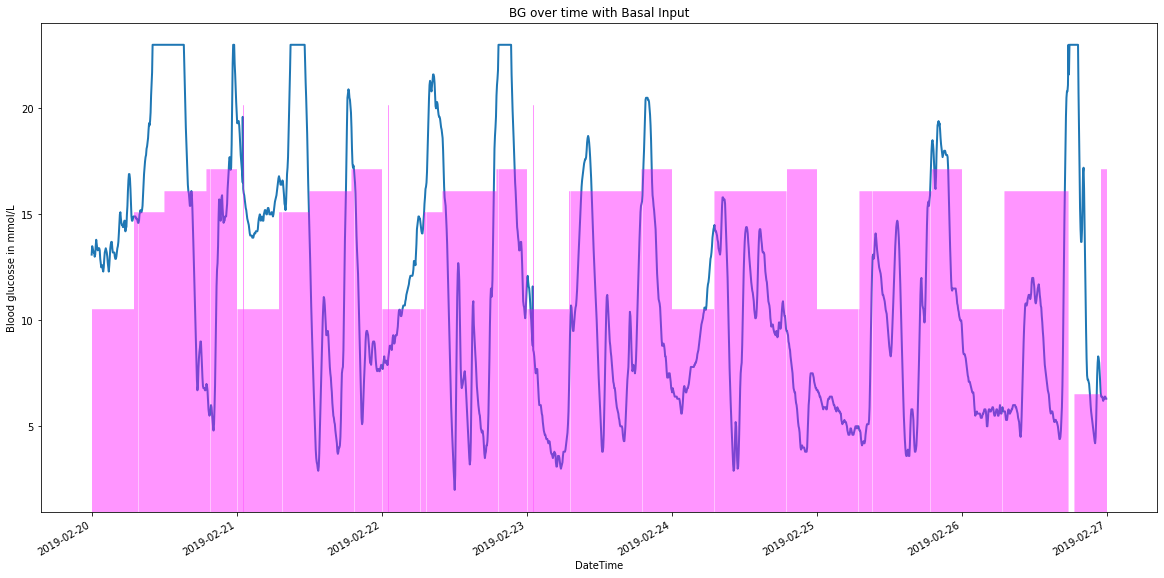

In [14]:
graph2 = filtered_idata['Glucose Value (mmol/L)'].plot.line(figsize=(20,10),title="BG over time with Basal Input",lw=2,)
graph2.set(xlabel="DateTime",ylabel='Blood glucosse in mmol/L')

max = filtered_idata['Basal'].max()
for y in filtered_idata.loc[(filtered_idata['Basal']>0),:].index:
  basal = float(filtered_idata.loc[(filtered_idata.index==y) & (filtered_idata['Basal']>0),'Basal'].sum())
  ymax = basal*0.7/max
  graph2.axvline(x=y,  ymin = 0.0, ymax = ymax, color='#ff00ff77',lw=0.5) #remember, transparency at the end


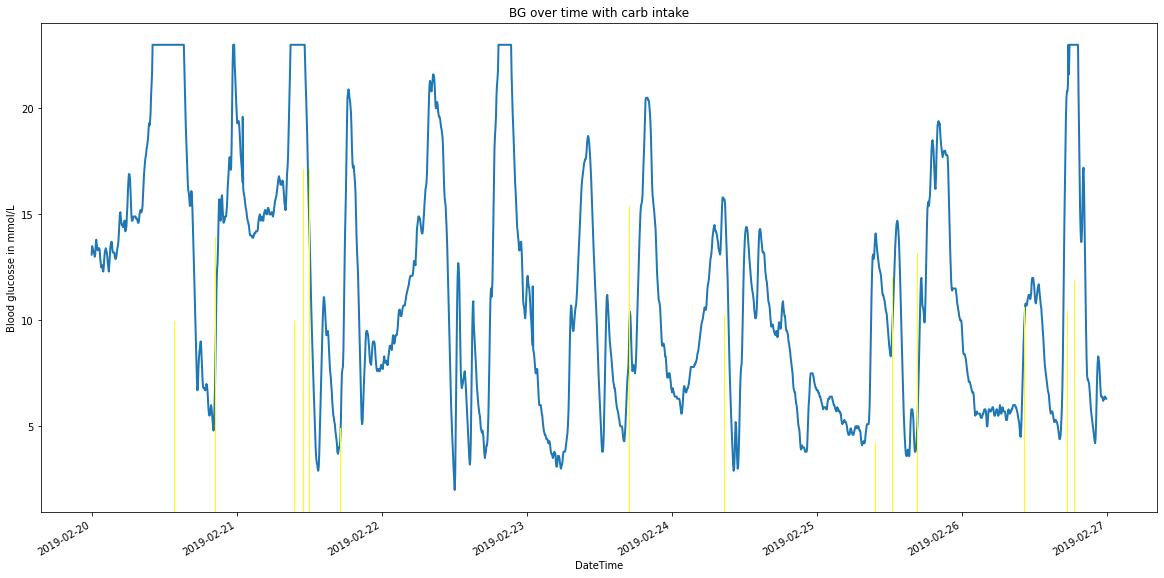

In [15]:
graph3 = filtered_idata['Glucose Value (mmol/L)'].plot.line(figsize=(20,10),title="BG over time with carb intake",lw=2,)
graph3.set(xlabel="DateTime",ylabel='Blood glucosse in mmol/L')

max = filtered_idata['Carbs_gm'].max()
for y in filtered_idata.loc[(filtered_idata['Carbs_gm']>0),:].index:
  carbs = float(filtered_idata.loc[(filtered_idata.index==y) & (filtered_idata['Carbs_gm']>0),'Carbs_gm'].sum())
  ymax = carbs*0.7/max
  graph3.axvline(x=y,  ymin = 0.0, ymax = ymax, color='#ffff00ff',lw=1) #remember, transparency at the end


# Train

## Config

In [16]:
#Model's Input
history_points = 120 #Number of history records needed to predict future BG value
batch_size=200 #Batch size of LSTM model execution
learning_rate=0.012 #Learning rate of LSTM model
validation_split=0.3 #validation data during training
prediction_horizon=3 #BG Prediction horizon: Value 1 = 5 minutes PH; Value 2 = 10 minutes PH; Value 6 = 30 minutes PH

## Create a training dataset

In [17]:
basal = 'basal'
bolus = 'bolus'
carbs = 'carbs'
bg = 'bg'
rename_legend= {
  'Basal':basal,
  'Bolus':bolus,
  'Carbs_gm':carbs, 
  'Glucose Value (mmol/L)':bg
}


In [18]:
train_data = filtered_idata.copy()
# dropped_features = ['Bolus Type','Immediate Volume (U)','Extended Volume (U)', 'Duration (min)']
# train_data.drop(dropped_features,1,inplace=True)
# temp_bg = filtered_bgdata.copy()
# do a manual join
# train_data['mmol/L'] = 0.0
print(len(train_data),'rows in training data')
# for index, row in temp_bg.iterrows():
#   # print(row[bg_unit],row.index)
#   l = train_data.loc[(train_data.index == index),bg_unit]
#   if len(l)>0:
#     train_data.loc[(train_data.index == index),bg_unit] = row[bg_unit]
#   else:
#     #insert a row
#     # print('inserting new row')
#     bg2 = row[bg_unit]
#     train_data = train_data.append(pd.Series({
#         'Basal Amount (U/h)':0.0, 
#         'Bolus Volume (U)':0.0, 
#         'Carbs(g)':0.0, 
#         bg_unit: bg2
#     }, name = index))
#     # train_data = pd.concat([train_data,df_new])

#rename columns
train_data.rename(rename_legend,axis=1,inplace=True)
train_data = train_data[ (train_data.index >= training_date[0]) & (train_data.index <= training_date[1]) ]
print(train_data.columns,'columns in training data')
print(len(train_data),'Data points in training data')
print(train_data)
print(train_data.info())

#Problem: The model is not working properly when intermittent glucose levels are not monitored.
# So we're setting them to the level last monitored
# train_data.sort_index(axis = 0,inplace=True)
# last_non_zero = 0.0
# for index,row in train_data.iterrows():
#   if(row[bg] <= 0):
#     row[bg] = last_non_zero
#   if(row[bg]>0):
#     last_non_zero = row[bg]
# train_data[bg].replace(0.0,np.nan,inplace=True)
# train_data[bg].interpolate(method='time',limit_direction ='forward',inplace=True)
# train_data[bg].fillna(0,inplace=True)

#export for manual inspection
train_data.to_csv('train-test1.csv')

2016 rows in training data
Index(['bg', 'basal', 'bolus', 'carbs'], dtype='object') columns in training data
576 Data points in training data
                       bg     basal  bolus  carbs
DateTime                                         
2019-02-21 01:00:00  19.6  0.079167    0.0      0
2019-02-21 00:05:00  19.3  0.079167    0.0      0
2019-02-21 00:10:00  19.3  0.079167    0.0      0
2019-02-21 00:15:00  19.4  0.079167    0.0      0
2019-02-21 00:20:00  19.4  0.079167    0.0      0
...                   ...       ...    ...    ...
2019-02-22 23:35:00  10.6  0.133333    0.0      0
2019-02-22 23:40:00  10.3  0.133333    0.0      0
2019-02-22 23:45:00  10.1  0.133333    0.0      0
2019-02-22 23:50:00  10.4  0.133333    0.0      0
2019-02-22 23:55:00  11.0  0.133333    0.0      0

[576 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 576 entries, 2019-02-21 01:00:00 to 2019-02-22 23:55:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  -

## Visualise training data

bg


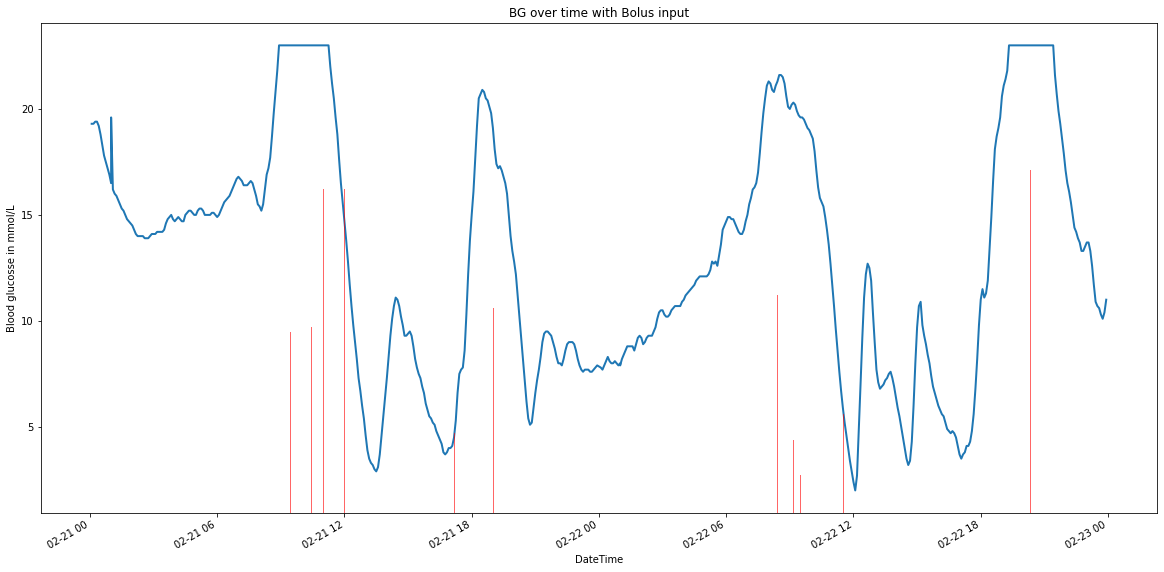

In [19]:
print(bg)
graph1 = train_data[bg].plot.line(figsize=(20,10),title="BG over time with Bolus input",lw=2,)
graph1.set(xlabel="DateTime",ylabel='Blood glucosse in mmol/L')

#plot bolus intake
max = train_data[bolus].max()
for y in train_data.loc[(train_data[bolus]>0)].index:
  # print(filtered_idata.loc[(filtered_idata.index==y) & (filtered_idata['Bolus Volume (U)']>0),'Bolus Volume (U)'].sum())
  bolu = float(train_data.loc[(train_data.index==y) & (train_data[bolus]>0),bolus].sum())
  ymax = bolu*0.7/max
  graph1.axvline(x=y,  ymin = 0.0, ymax = ymax, color='#ff000099',lw=1) #remember, transparency at the end


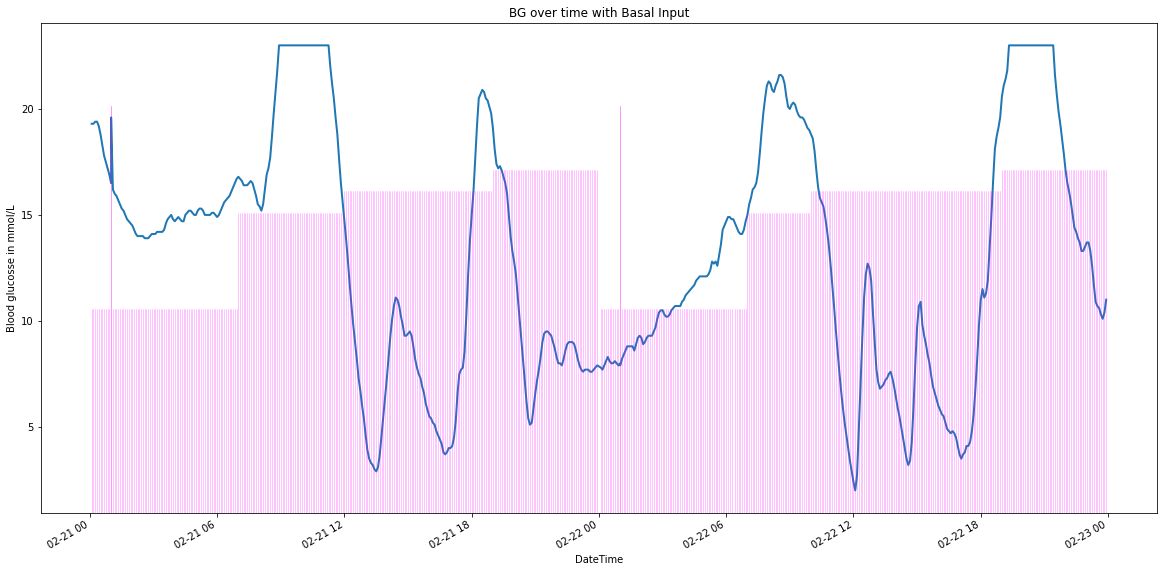

In [20]:
graph2 = train_data[bg].plot.line(figsize=(20,10),title="BG over time with Basal Input",lw=2,)
graph2.set(xlabel="DateTime",ylabel='Blood glucosse in mmol/L')

max = train_data[basal].max()
for y in train_data.loc[(train_data[basal]>0),:].index:
  basa = float(train_data.loc[(train_data.index==y) & (train_data[basal]>0),basal].sum())
  ymax = basa*0.7/max
  graph2.axvline(x=y,  ymin = 0.0, ymax = ymax, color='#ff00ff77',lw=0.5) #remember, transparency at the end


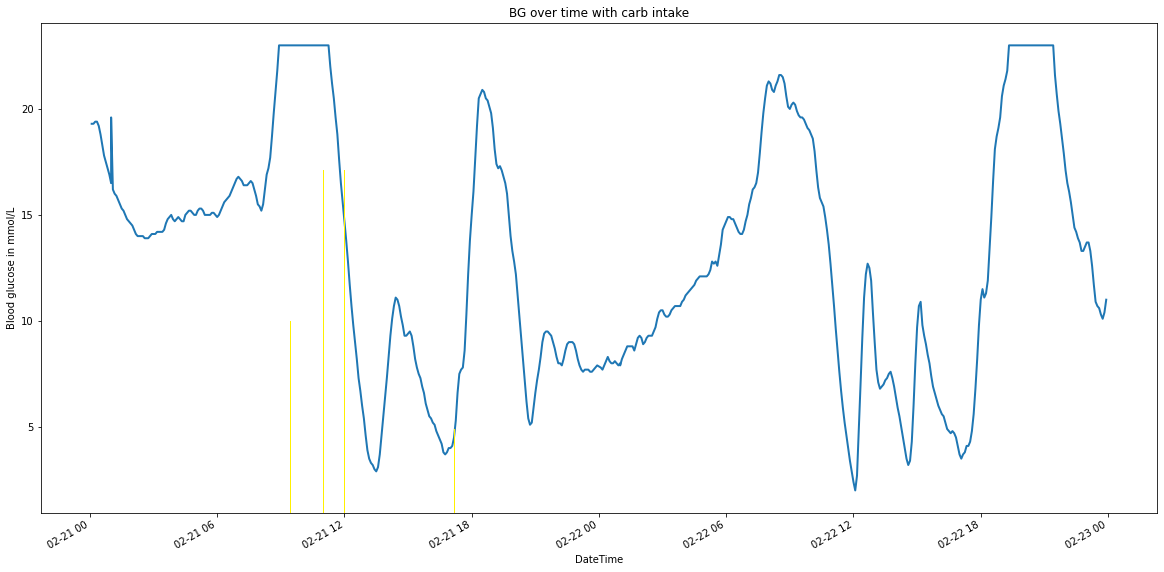

In [21]:
graph3 = train_data[bg].plot.line(figsize=(20,10),title="BG over time with carb intake",lw=2,)
graph3.set(xlabel="DateTime",ylabel='Blood glucose in mmol/L')

max = train_data[carbs].max()
for y in train_data.loc[(train_data[carbs]>0),:].index:
  carb = float(train_data.loc[(train_data.index==y) & (train_data[carbs]>0),carbs].sum())
  ymax = carb*0.7/max
  graph3.axvline(x=y,  ymin = 0.0, ymax = ymax, color='#fff000ff',lw=1) #remember, transparency at the end

## Prepare for training

In [22]:
normaliser = MinMaxScaler()
normalised_train = normaliser.fit_transform(train_data)

#For Denormalizing predicted BG data later
train_y = pd.DataFrame(train_data[bg])
scaler = MinMaxScaler()
scaler.fit_transform(train_y)

print(f'normalised train shape:{normalised_train.shape} \n', normalised_train)

#=========================================================================
#Preparing rows of data as a 3D-array of history points
#History points is the number of records needed to predict a future value

X_train = np.array([normalised_train[i : i + history_points].copy() for i in range(len(normalised_train) - history_points)])
y_train = np.array([normalised_train[:,0][i + history_points].copy() for i in range(len(normalised_train) - history_points)])

print(f'X_train_shape:{X_train.shape} \n')
print(f'y_train_shape: {y_train.shape} \n')

normalised train shape:(576, 4) 
 [[0.83809524 0.59375    0.         0.        ]
 [0.82380952 0.59375    0.         0.        ]
 [0.82380952 0.59375    0.         0.        ]
 ...
 [0.38571429 1.         0.         0.        ]
 [0.4        1.         0.         0.        ]
 [0.42857143 1.         0.         0.        ]]
X_train_shape:(456, 120, 4) 

y_train_shape: (456,) 



# Model

## Design

In [23]:
tf.random.set_seed(20)
np.random.seed(20)

#input shape of the model
input_properties = [bg,basal,bolus,carbs]
print(input_properties)
input_shape=(history_points, len(input_properties))

lstm_input = Input(shape=input_shape, name='lstm_input') #input layer
inputs = Dropout(0.49, name='dropout_0')(lstm_input)
inputs = LSTM(45, return_sequences=True, name='lstm_1')(inputs)
inputs = Dropout(0.49, name='dropout_1')(inputs)
inputs = LSTM(45, return_sequences=True, name='lstm_2')(inputs)
inputs = Dropout(0.49, name='dropout_2')(inputs)
inputs = LSTM(45, name='lstm_3')(inputs) #Note: return_sequences=True not given here
inputs = Dropout(0.49, name='dropout_3')(inputs)
inputs = Dense(prediction_horizon, name='dense_layer')(inputs) #output layer
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)

#Pick model optimizer
adam = tf.optimizers.Adam(learning_rate = learning_rate)
model.compile(optimizer=adam, loss='mse')

#Print model summary
stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
print(short_model_summary)

['bg', 'basal', 'bolus', 'carbs']
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 120, 4)]          0         
                                                                 
 dropout_0 (Dropout)         (None, 120, 4)            0         
                                                                 
 lstm_1 (LSTM)               (None, 120, 45)           9000      
                                                                 
 dropout_1 (Dropout)         (None, 120, 45)           0         
                                                                 
 lstm_2 (LSTM)               (None, 120, 45)           16380     
                                                                 
 dropout_2 (Dropout)         (None, 120, 45)           0         
                                                                 
 lstm_3 (LSTM)             

## Train

In [24]:
#Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) 

#Training and validation of data
model_train_start_time = time.time()
model_training = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=1000, callbacks=[es], validation_split = validation_split, shuffle=True)
elapsed_time = time.time() - model_train_start_time
n_epochs = len(model_training.history['loss'])
print('Training time: ', round(elapsed_time,3))

Epoch 1/1000
2/2 [==============================] - 9s 2s/step - loss: 0.2432 - val_loss: 0.2362
Epoch 2/1000
2/2 [==============================] - 1s 443ms/step - loss: 0.1685 - val_loss: 0.1578
Epoch 3/1000
2/2 [==============================] - 1s 443ms/step - loss: 0.1119 - val_loss: 0.0695
Epoch 4/1000
2/2 [==============================] - 1s 458ms/step - loss: 0.0793 - val_loss: 0.0628
Epoch 5/1000
2/2 [==============================] - 1s 441ms/step - loss: 0.0631 - val_loss: 0.0794
Epoch 6/1000
2/2 [==============================] - 1s 407ms/step - loss: 0.0614 - val_loss: 0.0397
Epoch 7/1000
2/2 [==============================] - 1s 414ms/step - loss: 0.0561 - val_loss: 0.0421
Epoch 8/1000
2/2 [==============================] - 1s 436ms/step - loss: 0.0420 - val_loss: 0.0483
Epoch 9/1000
2/2 [==============================] - 1s 460ms/step - loss: 0.0455 - val_loss: 0.0348
Epoch 10/1000
2/2 [==============================] - 1s 449ms/step - loss: 0.0420 - val_loss: 0.0321
Ep

## Check fit - testing on training data

method : {‘linear’, ‘time’, ‘index’, ‘values’, ‘nearest’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘barycentric’, ‘krogh’, ‘polynomial’, ‘spline’, ‘piecewise_polynomial’, ‘from_derivatives’, ‘pchip’, ‘akima’}

In [25]:
#=========================================================================
#Checking predictions of training data
#y-pred will return values equal to n-PH ahead
y_pred = model.predict(X_train)
y_pred = scaler.inverse_transform(y_pred)

#Getting the output equal to PH in a 2D array of 1 column
if prediction_horizon != 1:
    y_pred = y_pred[:,prediction_horizon-1]
    y_pred = np.reshape(y_pred, ((len(train_data)-history_points), 1))

y_pred.shape

#=========================================================================
#Predicted vs Actual value in training
#Adjusting y-pred data points consistent withactual y-values
train_result = train_data.iloc[history_points+prediction_horizon-1:]
train_result.rename(columns={bg: 'Actual Glucose Value (mmol/L)'}, inplace=True)
train_result['Predicted Glucose Value (mmol/L)'] = y_pred[:len(train_result),:] #Picking the first n predictions matching it with available actual value
train_result = train_result[['Actual Glucose Value (mmol/L)', 'Predicted Glucose Value (mmol/L)']] #Getting only Actual and Predicted values on mg/dl
# train_result['Actual Glucose Value (mmol/L)'] = train_result['Actual Glucose Value (mmol/L)'] / 18
# train_result['Predicted Glucose Value (mmol/L)'] = train_result['Predicted Glucose Value (mmol/L)'] / 18
train_result

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Actual Glucose Value (mmol/L),Predicted Glucose Value (mmol/L)
DateTime,,
2019-02-21 10:10:00,23.0,15.980446
2019-02-21 10:15:00,23.0,15.838032
2019-02-21 10:20:00,23.0,15.723440
2019-02-21 10:25:00,23.0,15.639235
2019-02-21 10:30:00,23.0,15.583996
...,...,...
2019-02-22 23:35:00,10.6,10.143592
2019-02-22 23:40:00,10.3,10.002342
2019-02-22 23:45:00,10.1,9.805756


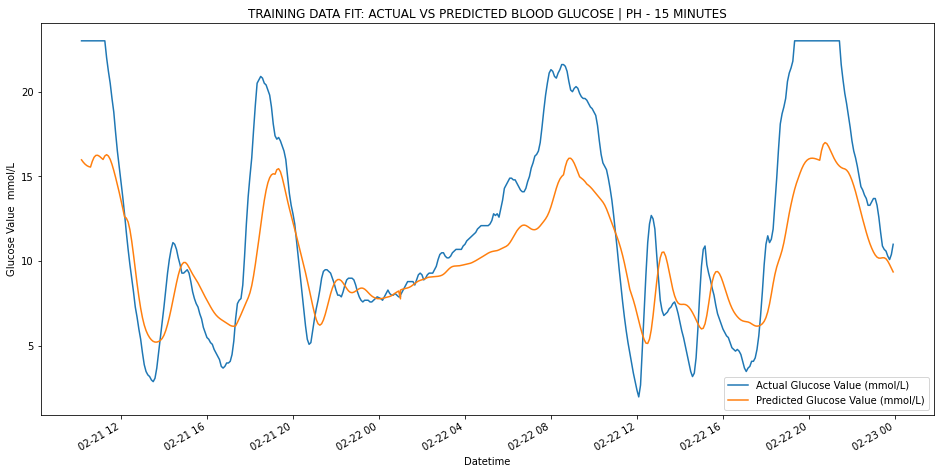

In [26]:
#=========================================================================
#Graph plot of training data fit
title = 'TRAINING DATA FIT: ACTUAL VS PREDICTED BLOOD GLUCOSE' + ' | ' + 'PH - ' + str(prediction_horizon*5) + ' MINUTES'
graph=train_result.plot.line(y=['Actual Glucose Value (mmol/L)', 'Predicted Glucose Value (mmol/L)'],figsize=(16,8),title=title)
graph.set(xlabel='Datetime',ylabel=bg_unit);

# Test on test data

## Create test dataset

In [ ]:
test_data = filtered_idata.copy()
print(len(test_data),'rows in test data')

#rename columns
test_data.rename(rename_legend,axis=1,inplace=True)
test_data = test_data[ (test_data.index >= testing_date[0]) & (test_data.index <= testing_date[1]) ]
print(test_data.columns,'columns in test data')
print(len(test_data),'Data points in test data')
print(test_data)
print(test_data.info())
test_data.to_csv('test-data-1.csv')

In [31]:
# test data 2 with no carb input
test_data2 = test_data.copy()
test_data2[carbs]=0
test_data2.to_csv('test-data-2.csv')

## Prep test data

In [ ]:
test_normalised_data = normaliser.transform(test_data)
print(f'test_normalised_data_shape: {test_normalised_data.shape} \n', test_normalised_data)
#Preparing rows of test data as a 3D-array of history points
#History points is the number of records needed to predict a future value
X_test = np.array([test_normalised_data[i : i + history_points].copy() for i in range(len(test_normalised_data) - history_points)])
print(f'X_test_shape:{X_test.shape} \n')

test_normalised_data_shape: (288, 4) 
 [[0.45714286 0.59375    0.         0.        ]
 [0.47619048 0.59375    0.         0.        ]
 [0.48095238 0.59375    0.14814815 0.        ]
 ...
 [0.25238095 1.         0.         0.        ]
 [0.24285714 1.         0.         0.        ]
 [0.22857143 1.         0.         0.        ]]
X_test_shape:(168, 120, 4) 



## Create a smaller window

In [ ]:
#=========================================================================
#Checking predictions of test data for one day window
#y-pred will return values equal to n-PH ahead

datapoints = 150

y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:datapoints,:] #Picking 150 datapoints of test results = around 1 Day of prediction

#Getting the output equal to PH in a 2D array of 1 column
if prediction_horizon != 1:
    y_pred = y_pred[:,prediction_horizon-1] #Picking last element from each predicted element array
    y_pred = np.reshape(y_pred, (datapoints, 1)) #Reshaping the 1D prediction to 2D array

y_pred.shape
#y_pred = y_pred[:283,0] #Used when history_points = 288

(150, 1)

## Predictions on test data

In [ ]:
#=========================================================================
#Predicted vs Actual value in testing for one day
#Adjusting y-pred data points consistent with actual y-values
test_result = test_data.iloc[history_points+prediction_horizon-1: (history_points+prediction_horizon-1)+datapoints]
test_result.rename(columns={'bg': 'Actual Glucose Value (mg/dl)'}, inplace=True)

if len(test_result) != datapoints:
    print('Test data not enough for prediction.')
    print('Please check the values passed in history_points, prediction_horizon and length of test data.')
    
test_result['Predicted Glucose Value (mg/dl)'] = y_pred
test_result.to_csv('test_result.csv')
test_result = test_result[['Actual Glucose Value (mg/dl)', 'Predicted Glucose Value (mg/dl)']] #Getting only Actual and Predicted values on mg/dl
test_result['Actual Glucose Value (mmol/L)'] = test_result['Actual Glucose Value (mg/dl)'] / 18
test_result['Predicted Glucose Value (mmol/L)'] = test_result['Predicted Glucose Value (mg/dl)'] / 18

#Get prediction result file (Uncomment the below two lines to generate the file)
#prediction_file_name = f'{experiment}_{testcase}_{model_name}_{patient}_Predictions{prediction_horizon*5}Min_{current_datetime}.xlsx'
#test_result.to_excel(prediction_file_name) #To get an excel file with prediction result
test_result

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,Actual Glucose Value (mg/dl),Predicted Glucose Value (mg/dl),Actual Glucose Value (mmol/L),Predicted Glucose Value (mmol/L)
DateTime,,,,
2019-02-23 10:10:00,18.7,13.142437,1.038889,0.730135
2019-02-23 10:15:00,18.6,13.196902,1.033333,0.733161
2019-02-23 10:20:00,18.4,13.265862,1.022222,0.736992
2019-02-23 10:25:00,18.1,13.342764,1.005556,0.741265
2019-02-23 10:30:00,17.7,13.411819,0.983333,0.745101
...,...,...,...,...
2019-02-23 22:15:00,9.6,9.060487,0.533333,0.503360
2019-02-23 22:20:00,9.1,8.920785,0.505556,0.495599
2019-02-23 22:25:00,8.8,8.808263,0.488889,0.489348


## Visualise test data prediction

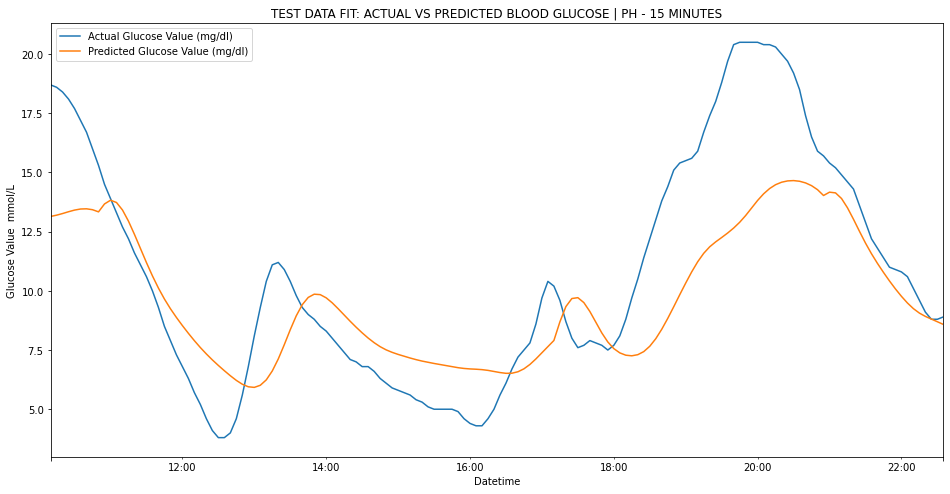

In [ ]:
#=========================================================================
#Graph plot of test data predictions
title = 'TEST DATA FIT: ACTUAL VS PREDICTED BLOOD GLUCOSE' + ' | ' + 'PH - ' + str(prediction_horizon*5) + ' MINUTES'
graph=test_result.plot.line(y=['Actual Glucose Value (mg/dl)', 'Predicted Glucose Value (mg/dl)'],figsize=(16,8),title=title)
graph.set(xlabel='Datetime',ylabel=bg_unit);
#graph.figure.savefig('filename.jpg') #Saves the below graph in jpeg format

# Evaluating test data predictions

## RMSE

In [ ]:
#Calclating RMSE between predicted and actual values

#Function to calculate RMSE
def rmse(preds, targets):
    return np.sqrt(((preds - targets) ** 2).mean())

#Converting actual BG value to numpy array
y_true = test_result.iloc[:,0].values #print(test_data.iloc[history_points+prediction_horizon-1:(history_points+prediction_horizon-1)+288, 0].values )
y_true = y_true.reshape(len(y_true),-1)
#print(y_true.shape)

#RMSE Value obtained
rmse_val = rmse(np.array(y_true), np.array(y_pred))
print(f'RMSE: {round(rmse_val,2)} mg/dl ({round(rmse_val/18,2)} mmol/L )')

RMSE: 3.06 mg/dl (0.17 mmol/L )


## CG-EGA
https://github.com/dotXem/CG-EGA

*Something's wrong with this*

In [ ]:
!git clone https://github.com/dotXem/CG-EGA
!mv CG-EGA cg_ega

Cloning into 'CG-EGA'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 103 (delta 4), reused 11 (delta 3), pack-reused 86
Receiving objects: 100% (103/103), 192.18 KiB | 2.40 MiB/s, done.
Resolving deltas: 100% (44/44), done.


AP, BE, EP: (1.0, 0.0, 0.0)


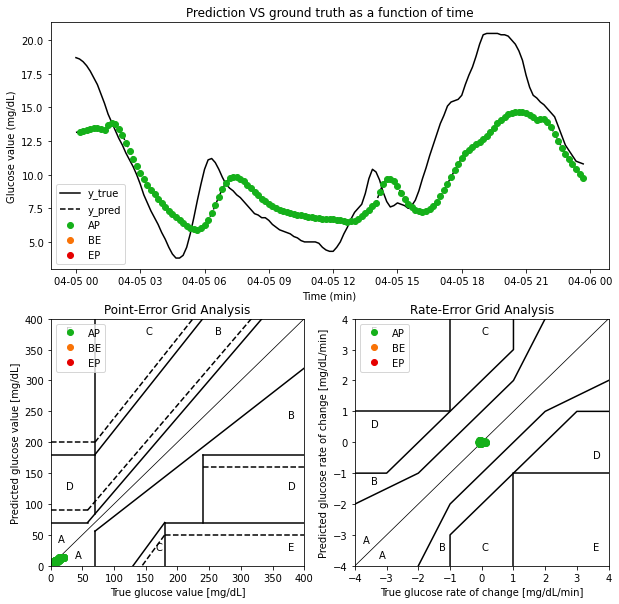

TEST DATA CG-EGA - AP: 1.0 | BE: 0.0 | EP: 0.0
Accurate Predictions: 100.0% 
Benign Errors: 0.0% 
Critical Error Predictions: 0.0%


In [ ]:
#CG-EGA function
#Source: https://github.com/dotXem/CG-EGA

#Transposing the true and predicted value 
#as the CG-EGA function accepts 1D array as (1, values)
y_true = y_true.T
y_pred = y_pred.T
#Result of CG-EGA evaluation
from cg_ega.cg_ega.cg_ega import CG_EGA
freq = 10 #Time-interval in minutes
results = pd.DataFrame(data = np.c_[y_true.reshape(-1,1), y_pred.reshape(-1,1)], columns=["y_true","y_pred"])
cg_ega = CG_EGA(results, freq)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=0)

#Write output in a result file
AP, BE, EP = cg_ega.reduced()
op_string = f'TEST DATA CG-EGA - AP: {round(AP,4)} | BE: {round(BE,4)} | EP: {round(EP,4)}'
op_string = op_string + f'\nAccurate Predictions: {round(AP,4)*100}% \nBenign Errors: {round(BE,4)*100}% \nCritical Error Predictions: {round(EP,4)*100}%'
print(op_string)

# Prepare for API

In [ ]:
def train_for_api():
  # Create training set
  train_data = filtered_idata.copy()
  print(len(train_data),'rows in training data')

  #rename columns
  train_data.rename(rename_legend,axis=1,inplace=True)
  train_data = train_data[ (train_data.index >= training_date[0]) & (train_data.index <= training_date[1]) ]
  print(train_data.columns,'columns in training data')
  print(len(train_data),'Data points in training data')
  print(train_data)
  print(train_data.info())
  train_data.to_csv('train-test1.csv')

  # Prepare data
  normaliser = MinMaxScaler()
  normalised_train = normaliser.fit_transform(train_data)

  #For Denormalizing predicted BG data later
  train_y = pd.DataFrame(train_data[bg])
  scaler = MinMaxScaler()
  scaler.fit_transform(train_y)

  print(f'normalised_train_shape:{normalised_train.shape} \n', normalised_train)

  #=========================================================================
  #Preparing rows of data as a 3D-array of history points
  #History points is the number of records needed to predict a future value

  X_train = np.array([normalised_train[i : i + history_points].copy() for i in range(len(normalised_train) - history_points)])
  y_train = np.array([normalised_train[:,0][i + history_points].copy() for i in range(len(normalised_train) - history_points)])

  print(f'X_train_shape:{X_train.shape} \n')
  print(f'y_train_shape: {y_train.shape} \n')

  # Design model
  tf.random.set_seed(20)
  np.random.seed(20)

  #input shape of the model
  input_properties = [bg,basal,bolus,carbs]
  print(input_properties)
  input_shape=(history_points, len(input_properties))

  lstm_input = Input(shape=input_shape, name='lstm_input') #input layer
  inputs = Dropout(0.5, name='dropout_0')(lstm_input)
  inputs = LSTM(50, return_sequences=True, name='lstm_1')(inputs)
  inputs = Dropout(0.5, name='dropout_1')(inputs)
  inputs = LSTM(50, return_sequences=True, name='lstm_2')(inputs)
  inputs = Dropout(0.5, name='dropout_2')(inputs)
  inputs = LSTM(50, name='lstm_3')(inputs) #Note: return_sequences=True not given here
  inputs = Dropout(0.5, name='dropout_3')(inputs)
  inputs = Dense(prediction_horizon, name='dense_layer')(inputs) #output layer
  output = Activation('linear', name='output')(inputs)
  model = Model(inputs=lstm_input, outputs=output)

  #Model optimizer
  adam = tf.optimizers.Adam(learning_rate = learning_rate)
  model.compile(optimizer=adam, loss='mse')

  #Model Summary
  stringlist = []
  model.summary(print_fn=lambda x: stringlist.append(x))
  short_model_summary = "\n".join(stringlist)
  print(short_model_summary)

  #Write output in a result file
  op_string = short_model_summary
  # start training
  #Early stopping
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) 

  #Training and validation of data
  model_train_start_time = time.time()
  model_training = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=1000, callbacks=[es], validation_split = validation_split, shuffle=True)
  elapsed_time = time.time() - model_train_start_time
  n_epochs = len(model_training.history['loss'])
  print('Training time: ', round(elapsed_time,2))


  #Write output in a result file
  op_string = f'Early stopping monitor: val_loss \nValidation split: {validation_split} \nNumber of epochs: {n_epochs} \nTraining time: {round(elapsed_time,2)} sec'

def test_for_api():
  # Create test data
  test_data = filtered_idata.copy()
  print(len(test_data),'rows in test data')

  #rename columns
  test_data.rename(rename_legend,axis=1,inplace=True)
  test_data = test_data[ (test_data.index >= testing_date[0]) & (test_data.index <= testing_date[1]) ]
  print(test_data.columns,'columns in test data')
  print(len(test_data),'Data points in test data')
  print(test_data)
  print(test_data.info())
  test_data.to_csv('test-data-1.csv')

  # normalise
  test_normalised_data = normaliser.transform(test_data)
  print(f'test_normalised_data_shape: {test_normalised_data.shape} \n', test_normalised_data)
  #Preparing rows of test data as a 3D-array of history points
  #History points is the number of records needed to predict a future value
  X_test = np.array([test_normalised_data[i : i + history_points].copy() for i in range(len(test_normalised_data) - history_points)])
  print(f'X_test_shape:{X_test.shape} \n')

  #=========================================================================
  #Checking predictions of test data for one day window
  #y-pred will return values equal to n-PH ahead

  datapoints = 150

  y_pred = model.predict(X_test)
  y_pred = scaler.inverse_transform(y_pred)
  y_pred = y_pred[:datapoints,:] #Picking 100 datapoints of test results = 1 Day of prediction

  #Getting the output equal to PH in a 2D array of 1 column
  if prediction_horizon != 1:
      y_pred = y_pred[:,prediction_horizon-1] #Picking last element from each predicted element array
      y_pred = np.reshape(y_pred, (datapoints, 1)) #Reshaping the 1D prediction to 2D array

  y_pred.shape
  #y_pred = y_pred[:283,0] #Used when history_points = 288

  #=========================================================================
  #Predicted vs Actual value in testing for one day
  #Adjusting y-pred data points consistent with actual y-values
  test_result = test_data.iloc[history_points+prediction_horizon-1: (history_points+prediction_horizon-1)+datapoints]
  test_result.rename(columns={'bg': 'Actual Glucose Value (mg/dl)'}, inplace=True)

  if len(test_result) != datapoints:
      print('Test data not enough for prediction.')
      print('Please check the values passed in history_points, prediction_horizon and length of test data.')
  print('writing test results')
  print('y_pred is',y_pred)
  test_result['Predicted Glucose Value (mg/dl)'] = y_pred
  test_result.to_csv('test_result.csv')
  test_result = test_result[['Actual Glucose Value (mg/dl)', 'Predicted Glucose Value (mg/dl)']] #Getting only Actual and Predicted values on mg/dl
  test_result['Actual Glucose Value (mmol/L)'] = test_result['Actual Glucose Value (mg/dl)'] / 18
  test_result['Predicted Glucose Value (mmol/L)'] = test_result['Predicted Glucose Value (mg/dl)'] / 18

  #Get prediction result file (Uncomment the below two lines to generate the file)
  #prediction_file_name = f'{experiment}_{testcase}_{model_name}_{patient}_Predictions{prediction_horizon*5}Min_{current_datetime}.xlsx'
  #test_result.to_excel(prediction_file_name) #To get an excel file with prediction result
  test_result_name = 'outputs/test-result-'+str(prediction_horizon*5)+'.csv'
  print('saving test results to',test_result_name)
  test_result.to_csv(test_result_name)

  #Calclating RMSE between predicted and actual values

  #Converting actual BG value to numpy array
  y_true = test_result.iloc[:,0].values #print(test_data.iloc[history_points+prediction_horizon-1:(history_points+prediction_horizon-1)+288, 0].values )
  y_true = y_true.reshape(len(y_true),-1)
  #print(y_true.shape)

  #RMSE Value obtained
  rmse_val = rmse(np.array(y_true), np.array(y_pred))
  print(f'RMSE: {round(rmse_val,2)} mg/dl ({round(rmse_val/18,2)} mmol/L )')
  
  data[prediction_horizon*5] = {
      'rmse': round(rmse_val/18,2),
      'unit':'minutes',
      'start_date':training_start,
      'end_date:':training_end,
      'test_date':testing_date,
      'test_path':test_result_name
  }
  print('data written')

  #Write output in a result file
  # op_string = f'TEST DATA RMSE: {round(rmse_val,2)} mg/dl ({round(rmse_val/18,2)} mmol/L )'
  # write_file( test_file_name, 'a', op_string)

#Function to calculate RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


In [ ]:
import json
!rm -rf outputs && mkdir outputs
data = {}
horizons = [1,3,6]
for horizon in horizons:
  prediction_horizon = horizon
  train_for_api()
  test_for_api()

data['user'] = {
    'name':patient_name,
    'gender':gender
}
dfile = open('outputs/data.json','w')
dfile.write(json.dumps(data))
print('data',data)

2016 rows in training data
Index(['bg', 'basal', 'bolus', 'carbs'], dtype='object') columns in training data
576 Data points in training data
                       bg     basal  bolus  carbs
DateTime                                         
2019-02-21 01:00:00  19.6  0.079167    0.0      0
2019-02-21 00:05:00  19.3  0.079167    0.0      0
2019-02-21 00:10:00  19.3  0.079167    0.0      0
2019-02-21 00:15:00  19.4  0.079167    0.0      0
2019-02-21 00:20:00  19.4  0.079167    0.0      0
...                   ...       ...    ...    ...
2019-02-22 23:35:00  10.6  0.133333    0.0      0
2019-02-22 23:40:00  10.3  0.133333    0.0      0
2019-02-22 23:45:00  10.1  0.133333    0.0      0
2019-02-22 23:50:00  10.4  0.133333    0.0      0
2019-02-22 23:55:00  11.0  0.133333    0.0      0

[576 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 576 entries, 2019-02-21 01:00:00 to 2019-02-22 23:55:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  -

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


writing test results
y_pred is [[13.084642  12.99026   13.142437 ]
 [13.141773  13.043056  13.196902 ]
 [13.212238  13.11002   13.265862 ]
 [13.289472  13.185386  13.342764 ]
 [13.358109  13.254072  13.411819 ]
 [13.402981  13.300348  13.457168 ]
 [13.411721  13.310921  13.465769 ]
 [13.375143  13.27578   13.427995 ]
 [13.286679  13.187901  13.337179 ]
 [13.630845  13.491226  13.671004 ]
 [13.798016  13.64547   13.827978 ]
 [13.706111  13.565382  13.732918 ]
 [13.38961   13.26864   13.415831 ]
 [12.919345  12.8152275 12.944605 ]
 [12.36056   12.267413  12.384363 ]
 [11.763817  11.677467  11.787354 ]
 [11.168927  11.08809   11.19534  ]
 [10.599172  10.525425  10.632923 ]
 [10.0712595 10.007424  10.116893 ]
 [ 9.594413   9.543398   9.655532 ]
 [ 9.167408   9.131797   9.246157 ]
 [ 8.780477   8.762361   8.877382 ]
 [ 8.418726   8.4197     8.53282  ]
 [ 8.077418   8.097719   8.206245 ]
 [ 7.7555103  7.7944155  7.8956866]
 [ 7.45654    7.512606   7.6042113]
 [ 7.183248   7.2548804  7.334581

ValueError: ignored

# API 2

In [35]:
def run_api():
  """## Create a training dataset"""

  basal = 'basal'
  bolus = 'bolus'
  carbs = 'carbs'
  bg = 'bg'
  rename_legend= {
    'Basal':basal,
    'Bolus':bolus,
    'Carbs_gm':carbs, 
    'Glucose Value (mmol/L)':bg
  }

  train_data = filtered_idata.copy()
  print(len(train_data),'rows in training data')

  #rename columns
  train_data.rename(rename_legend,axis=1,inplace=True)
  train_data = train_data[ (train_data.index >= training_date[0]) & (train_data.index <= training_date[1]) ]
  print(train_data.columns,'columns in training data')
  print(len(train_data),'Data points in training data')
  print(train_data)
  print(train_data.info())
  #export for manual inspection
  train_data.to_csv('train-test1.csv')

  """## Visualise training data"""

  print(bg)
  graph1 = train_data[bg].plot.line(figsize=(20,10),title="BG over time with Bolus input",lw=2,)
  graph1.set(xlabel="DateTime",ylabel='Blood glucosse in mmol/L')


  INPUT_GRAPH_PREFIX = "outputs/ipgraph-"
  input_graphs = []
  #plot bolus intake
  max = train_data[bolus].max()
  for y in train_data.loc[(train_data[bolus]>0)].index:
    # print(filtered_idata.loc[(filtered_idata.index==y) & (filtered_idata['Bolus Volume (U)']>0),'Bolus Volume (U)'].sum())
    bolu = float(train_data.loc[(train_data.index==y) & (train_data[bolus]>0),bolus].sum())
    ymax = bolu*0.7/max
    graph1.axvline(x=y,  ymin = 0.0, ymax = ymax, color='#ff000099',lw=1) #remember, transparency at the end
  gname = INPUT_GRAPH_PREFIX+str(prediction_horizon)+"-1.png"
  input_graphs.append(gname)
  graph1.figure.savefig(gname)  

  graph2 = train_data[bg].plot.line(figsize=(20,10),title="BG over time with Basal Input",lw=2,)
  graph2.set(xlabel="DateTime",ylabel='Blood glucosse in mmol/L')

  max = train_data[basal].max()
  for y in train_data.loc[(train_data[basal]>0),:].index:
    basa = float(train_data.loc[(train_data.index==y) & (train_data[basal]>0),basal].sum())
    ymax = basa*0.7/max
    graph2.axvline(x=y,  ymin = 0.0, ymax = ymax, color='#ff00ff77',lw=0.5) #remember, transparency at the end
  
  gname = INPUT_GRAPH_PREFIX+str(prediction_horizon)+"-2.png"
  input_graphs.append(gname)
  graph2.figure.savefig(gname)

  graph3 = train_data[bg].plot.line(figsize=(20,10),title="BG over time with carb intake",lw=2,)
  graph3.set(xlabel="DateTime",ylabel='Blood glucose in mmol/L')

  max = train_data[carbs].max()
  for y in train_data.loc[(train_data[carbs]>0),:].index:
    carb = float(train_data.loc[(train_data.index==y) & (train_data[carbs]>0),carbs].sum())
    ymax = carb*0.7/max
    graph3.axvline(x=y,  ymin = 0.0, ymax = ymax, color='#fff000ff',lw=1) #remember, transparency at the end
  gname = INPUT_GRAPH_PREFIX+str(prediction_horizon)+"-3.png"
  input_graphs.append(gname)
  graph3.figure.savefig(gname)

  """## Prepare for training"""

  normaliser = MinMaxScaler()
  normalised_train = normaliser.fit_transform(train_data)

  #For Denormalizing predicted BG data later
  train_y = pd.DataFrame(train_data[bg])
  scaler = MinMaxScaler()
  scaler.fit_transform(train_y)

  print(f'normalised train shape:{normalised_train.shape} \n', normalised_train)

  X_train = np.array([normalised_train[i : i + history_points].copy() for i in range(len(normalised_train) - history_points)])
  y_train = np.array([normalised_train[:,0][i + history_points].copy() for i in range(len(normalised_train) - history_points)])

  print(f'X_train_shape:{X_train.shape} \n')
  print(f'y_train_shape: {y_train.shape} \n')

  """# Model

  ## Design
  """

  tf.random.set_seed(20)
  np.random.seed(20)

  #input shape of the model
  input_properties = [bg,basal,bolus,carbs]
  print(input_properties)
  input_shape=(history_points, len(input_properties))

  lstm_input = Input(shape=input_shape, name='lstm_input') #input layer
  inputs = Dropout(0.49, name='dropout_0')(lstm_input)
  inputs = LSTM(45, return_sequences=True, name='lstm_1')(inputs)
  inputs = Dropout(0.49, name='dropout_1')(inputs)
  inputs = LSTM(45, return_sequences=True, name='lstm_2')(inputs)
  inputs = Dropout(0.49, name='dropout_2')(inputs)
  inputs = LSTM(45, name='lstm_3')(inputs) #Note: return_sequences=True not given here
  inputs = Dropout(0.49, name='dropout_3')(inputs)
  inputs = Dense(prediction_horizon, name='dense_layer')(inputs) #output layer
  output = Activation('linear', name='output')(inputs)
  model = Model(inputs=lstm_input, outputs=output)

  #Pick model optimizer
  adam = tf.optimizers.Adam(learning_rate = learning_rate)
  model.compile(optimizer=adam, loss='mse')

  #Print model summary
  stringlist = []
  model.summary(print_fn=lambda x: stringlist.append(x))
  short_model_summary = "\n".join(stringlist)
  print(short_model_summary)

  """## Train"""

  #Early stopping
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) 

  #Training and validation of data
  model_train_start_time = time.time()
  model_training = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=1000, callbacks=[es], validation_split = validation_split, shuffle=True)
  elapsed_time = time.time() - model_train_start_time
  n_epochs = len(model_training.history['loss'])
  print('Training time: ', round(elapsed_time,3))

  """## Check fit - testing on training data

  method : {‘linear’, ‘time’, ‘index’, ‘values’, ‘nearest’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘barycentric’, ‘krogh’, ‘polynomial’, ‘spline’, ‘piecewise_polynomial’, ‘from_derivatives’, ‘pchip’, ‘akima’}
  """
  y_pred = model.predict(X_train)
  y_pred = scaler.inverse_transform(y_pred)

  #Getting the output equal to PH in a 2D array of 1 column
  if prediction_horizon != 1:
      y_pred = y_pred[:,prediction_horizon-1]
      y_pred = np.reshape(y_pred, ((len(train_data)-history_points), 1))

  y_pred.shape

  #=========================================================================
  #Predicted vs Actual value in training
  #Adjusting y-pred data points consistent withactual y-values
  train_result = train_data.iloc[history_points+prediction_horizon-1:]
  train_result.rename(columns={bg: 'Actual Glucose Value (mmol/L)'}, inplace=True)
  train_result['Predicted Glucose Value (mmol/L)'] = y_pred[:len(train_result),:] #Picking the first n predictions matching it with available actual value
  train_result = train_result[['Actual Glucose Value (mmol/L)', 'Predicted Glucose Value (mmol/L)']] #Getting only Actual and Predicted values on mg/dl
  # train_result['Actual Glucose Value (mmol/L)'] = train_result['Actual Glucose Value (mmol/L)'] / 18
  # train_result['Predicted Glucose Value (mmol/L)'] = train_result['Predicted Glucose Value (mmol/L)'] / 18
  train_result

  #=========================================================================
  #Graph plot of training data fit
  title = 'TRAINING DATA FIT: ACTUAL VS PREDICTED BLOOD GLUCOSE' + ' | ' + 'PH - ' + str(prediction_horizon*5) + ' MINUTES'
  graph=train_result.plot.line(y=['Actual Glucose Value (mmol/L)', 'Predicted Glucose Value (mmol/L)'],figsize=(16,8),title=title)
  graph.set(xlabel='Datetime',ylabel=bg_unit);

  trainfit_graph = "outputs/trainfit-"+str(prediction_horizon)+'.png'
  graph.figure.savefig(trainfit_graph)

  """# Test on test data

  ## Create test dataset
  """

  test_data = filtered_idata.copy()
  print(len(test_data),'rows in test data')

  #rename columns
  test_data.rename(rename_legend,axis=1,inplace=True)
  test_data = test_data[ (test_data.index >= testing_date[0]) & (test_data.index <= testing_date[1]) ]
  print(test_data.columns,'columns in test data')
  print(len(test_data),'Data points in test data')
  print(test_data)
  print(test_data.info())
  test_data['carbs']=0
  test_data['basal']=0
  test_data['bolus']=0
  test_data.to_csv('test-data-1.csv')

  """## Prep test data"""

  test_normalised_data = normaliser.transform(test_data)
  print(f'test_normalised_data_shape: {test_normalised_data.shape} \n', test_normalised_data)
  #Preparing rows of test data as a 3D-array of history points
  #History points is the number of records needed to predict a future value
  X_test = np.array([test_normalised_data[i : i + history_points].copy() for i in range(len(test_normalised_data) - history_points)])
  print(f'X_test_shape:{X_test.shape} \n')

  """## Create a smaller window"""

  #=========================================================================
  #Checking predictions of test data for one day window
  #y-pred will return values equal to n-PH ahead

  datapoints = datapoints_map[prediction_horizon]

  y_pred = model.predict(X_test)
  y_pred = scaler.inverse_transform(y_pred)
  y_pred = y_pred[:datapoints,:] #Picking 150 datapoints of test results = around 1 Day of prediction

  #Getting the output equal to PH in a 2D array of 1 column
  if prediction_horizon != 1:
      y_pred = y_pred[:,prediction_horizon-1] #Picking last element from each predicted element array
      y_pred = np.reshape(y_pred, (datapoints, 1)) #Reshaping the 1D prediction to 2D array

  y_pred.shape
  #y_pred = y_pred[:283,0] #Used when history_points = 288

  """## Predictions on test data"""

  #=========================================================================
  #Predicted vs Actual value in testing for one day
  #Adjusting y-pred data points consistent with actual y-values
  test_result = test_data.iloc[history_points+prediction_horizon-1: (history_points+prediction_horizon-1)+datapoints]
  test_result.rename(columns={'bg': 'Actual Glucose Value (mg/dl)'}, inplace=True)

  if len(test_result) != datapoints:
      print('Test data not enough for prediction.')
      print('Please check the values passed in history_points, prediction_horizon and length of test data.')
      
  test_result['Predicted Glucose Value (mg/dl)'] = y_pred
  test_result.to_csv('test_result.csv')
  test_result = test_result[['Actual Glucose Value (mg/dl)', 'Predicted Glucose Value (mg/dl)']] #Getting only Actual and Predicted values on mg/dl
  test_result['Actual Glucose Value (mmol/L)'] = test_result['Actual Glucose Value (mg/dl)'] / 18
  test_result['Predicted Glucose Value (mmol/L)'] = test_result['Predicted Glucose Value (mg/dl)'] / 18

  #Get prediction result file (Uncomment the below two lines to generate the file)
  #prediction_file_name = f'{experiment}_{testcase}_{model_name}_{patient}_Predictions{prediction_horizon*5}Min_{current_datetime}.xlsx'
  #test_result.to_excel(prediction_file_name) #To get an excel file with prediction result
  # test_result
  # api
  output_file = 'outputs/'+str(prediction_horizon*5)+'-test_data_output.json'
  test_result.to_json(output_file)

  """## Visualise test data prediction"""

  #=========================================================================
  #Graph plot of test data predictions
  # title = 'TEST DATA FIT: ACTUAL VS PREDICTED BLOOD GLUCOSE' + ' | ' + 'PH - ' + str(prediction_horizon*5) + ' MINUTES'
  # graph=test_result.plot.line(y=['Actual Glucose Value (mg/dl)', 'Predicted Glucose Value (mg/dl)'],figsize=(16,8),title=title)
  title = 'PREDICTED BLOOD GLUCOSE' + ' | ' + 'PH - ' + str(prediction_horizon*5) + ' MINUTES'
  graph=test_result.plot.line(y=['Predicted Glucose Value (mg/dl)'],figsize=(16,8),title=title)
  graph.set(xlabel='Datetime',ylabel=bg_unit);
  test_graph_name = 'outputs/test'+str(prediction_horizon)+'.png'
  graph.figure.savefig(test_graph_name) 

  """# Evaluating test data predictions

  ## RMSE
  """

  #Calclating RMSE between predicted and actual values

  #Function to calculate RMSE
  def rmse(preds, targets):
      return np.sqrt(((preds - targets) ** 2).mean())

  #Converting actual BG value to numpy array
  y_true = test_result.iloc[:,0].values #print(test_data.iloc[history_points+prediction_horizon-1:(history_points+prediction_horizon-1)+288, 0].values )
  y_true = y_true.reshape(len(y_true),-1)
  #print(y_true.shape)

  #RMSE Value obtained
  rmse_val = rmse(np.array(y_true), np.array(y_pred))
  print(f'RMSE: {round(rmse_val,2)} mg/dl ({round(rmse_val/18,2)} mmol/L )')

  """## CG-EGA
  https://github.com/dotXem/CG-EGA

  *Something's wrong with this*
  """

  !git clone https://github.com/dotXem/CG-EGA
  !mv CG-EGA cg_ega

  d = {
    API_UNIT:"minutes",
    API_HORIZON_TIME:prediction_horizon*5,
    API_RMSE: f'RMSE: {round(rmse_val,2)} mg/dl',
    API_TEST_PATH: output_file,
    API_GRAPH_TEST: test_graph_name,
    API_GRAPH_INPUTS: input_graphs,
    API_GRAPH_FIT: trainfit_graph
  }
  pred_data.append(d)
  #CG-EGA function
  #Source: https://github.com/dotXem/CG-EGA

  #Transposing the true and predicted value 
  #as the CG-EGA function accepts 1D array as (1, values)
  y_true = y_true.T
  y_pred = y_pred.T
  #Result of CG-EGA evaluation
  from cg_ega.cg_ega.cg_ega import CG_EGA
  freq = 10 #Time-interval in minutes
  results = pd.DataFrame(data = np.c_[y_true.reshape(-1,1), y_pred.reshape(-1,1)], columns=["y_true","y_pred"])
  cg_ega = CG_EGA(results, freq)
  print("AP, BE, EP:", cg_ega.reduced())
  cg_ega.plot(day=0)

  AP, BE, EP = cg_ega.reduced()
  op_string = f'TEST DATA CG-EGA - AP: {round(AP,4)} | BE: {round(BE,4)} | EP: {round(EP,4)}'
  op_string = op_string + f'\nAccurate Predictions: {round(AP,4)*100}% \nBenign Errors: {round(BE,4)*100}% \nCritical Error Predictions: {round(EP,4)*100}%'
  print(op_string)

In [36]:
# API constants
# Oops Python has no constants

API_USER = "user"
API_USER_NAME = "name"
API_USER_GENDER = "gender"

API_HORIZONS = "h"
API_HORIZON_TIME = 'time'
API_HORIZON_PREDICTION_FILE = 'prediction'
API_RMSE = "rmse"
API_UNIT = "unit"
API_START_DATE = "start_date"
API_END_DATE = "stop_date"
API_TEST_DATE = 'test_date'
API_TEST_PATH = "test_prediction_path"

#graph outputs
API_GRAPH_TEST = "graph_test"

API_HELPER_GRAPHS = "analysis_graphs"
API_GRAPH_FIT = "graph_fit"
API_GRAPH_INPUTS = "input_graphs"


2016 rows in training data
Index(['bg', 'basal', 'bolus', 'carbs'], dtype='object') columns in training data
576 Data points in training data
                       bg     basal  bolus  carbs
DateTime                                         
2019-02-21 01:00:00  19.6  0.079167    0.0      0
2019-02-21 00:05:00  19.3  0.079167    0.0      0
2019-02-21 00:10:00  19.3  0.079167    0.0      0
2019-02-21 00:15:00  19.4  0.079167    0.0      0
2019-02-21 00:20:00  19.4  0.079167    0.0      0
...                   ...       ...    ...    ...
2019-02-22 23:35:00  10.6  0.133333    0.0      0
2019-02-22 23:40:00  10.3  0.133333    0.0      0
2019-02-22 23:45:00  10.1  0.133333    0.0      0
2019-02-22 23:50:00  10.4  0.133333    0.0      0
2019-02-22 23:55:00  11.0  0.133333    0.0      0

[576 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 576 entries, 2019-02-21 01:00:00 to 2019-02-22 23:55:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  -

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2016 rows in test data
Index(['bg', 'basal', 'bolus', 'carbs'], dtype='object') columns in test data
288 Data points in test data
                       bg     basal  bolus  carbs
DateTime                                         
2019-02-23 01:00:00  11.6  0.079167    0.0      0
2019-02-23 00:05:00  12.0  0.079167    0.0      0
2019-02-23 00:10:00  12.1  0.079167    1.6      0
2019-02-23 00:15:00  11.8  0.079167    0.0      0
2019-02-23 00:20:00  11.6  0.079167    0.0      0
...                   ...       ...    ...    ...
2019-02-23 23:35:00   7.5  0.133333    0.0      0
2019-02-23 23:40:00   7.5  0.133333    0.0      0
2019-02-23 23:45:00   7.3  0.133333    0.0      0
2019-02-23 23:50:00   7.1  0.133333    0.0      0
2019-02-23 23:55:00   6.8  0.133333    0.0      0

[288 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2019-02-23 01:00:00 to 2019-02-23 23:55:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  -----

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RMSE: 2.43 mg/dl (0.14 mmol/L )
fatal: destination path 'CG-EGA' already exists and is not an empty directory.
mv: cannot move 'CG-EGA' to 'cg_ega/CG-EGA': Directory not empty
AP, BE, EP: (1.0, 0.0, 0.0)


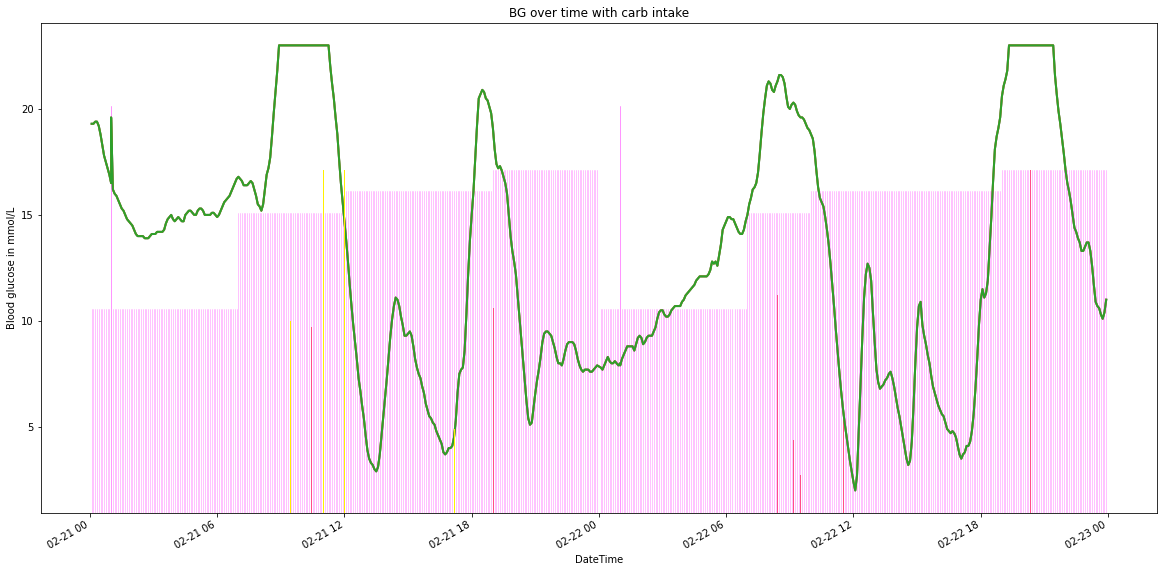

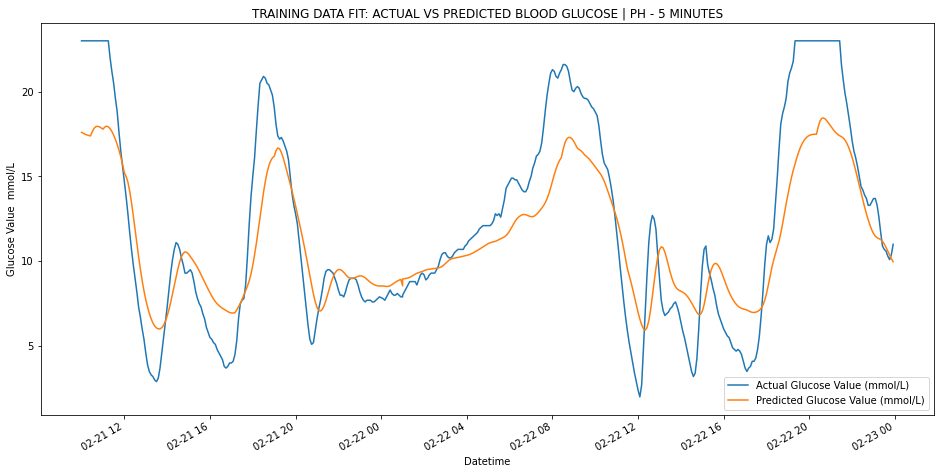

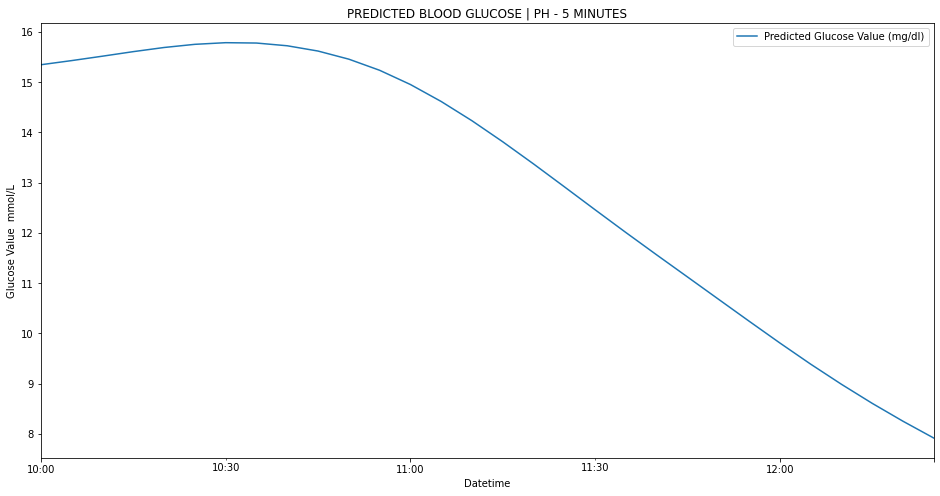

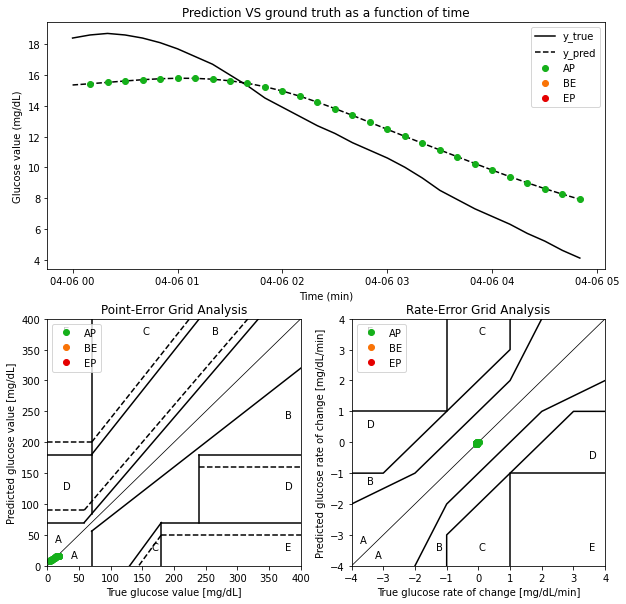

TEST DATA CG-EGA - AP: 1.0 | BE: 0.0 | EP: 0.0
Accurate Predictions: 100.0% 
Benign Errors: 0.0% 
Critical Error Predictions: 0.0%
2016 rows in training data
Index(['bg', 'basal', 'bolus', 'carbs'], dtype='object') columns in training data
576 Data points in training data
                       bg     basal  bolus  carbs
DateTime                                         
2019-02-21 01:00:00  19.6  0.079167    0.0      0
2019-02-21 00:05:00  19.3  0.079167    0.0      0
2019-02-21 00:10:00  19.3  0.079167    0.0      0
2019-02-21 00:15:00  19.4  0.079167    0.0      0
2019-02-21 00:20:00  19.4  0.079167    0.0      0
...                   ...       ...    ...    ...
2019-02-22 23:35:00  10.6  0.133333    0.0      0
2019-02-22 23:40:00  10.3  0.133333    0.0      0
2019-02-22 23:45:00  10.1  0.133333    0.0      0
2019-02-22 23:50:00  10.4  0.133333    0.0      0
2019-02-22 23:55:00  11.0  0.133333    0.0      0

[576 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2016 rows in test data
Index(['bg', 'basal', 'bolus', 'carbs'], dtype='object') columns in test data
288 Data points in test data
                       bg     basal  bolus  carbs
DateTime                                         
2019-02-23 01:00:00  11.6  0.079167    0.0      0
2019-02-23 00:05:00  12.0  0.079167    0.0      0
2019-02-23 00:10:00  12.1  0.079167    1.6      0
2019-02-23 00:15:00  11.8  0.079167    0.0      0
2019-02-23 00:20:00  11.6  0.079167    0.0      0
...                   ...       ...    ...    ...
2019-02-23 23:35:00   7.5  0.133333    0.0      0
2019-02-23 23:40:00   7.5  0.133333    0.0      0
2019-02-23 23:45:00   7.3  0.133333    0.0      0
2019-02-23 23:50:00   7.1  0.133333    0.0      0
2019-02-23 23:55:00   6.8  0.133333    0.0      0

[288 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2019-02-23 01:00:00 to 2019-02-23 23:55:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  -----

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RMSE: 2.96 mg/dl (0.16 mmol/L )
fatal: destination path 'CG-EGA' already exists and is not an empty directory.
mv: cannot move 'CG-EGA' to 'cg_ega/CG-EGA': Directory not empty
AP, BE, EP: (1.0, 0.0, 0.0)


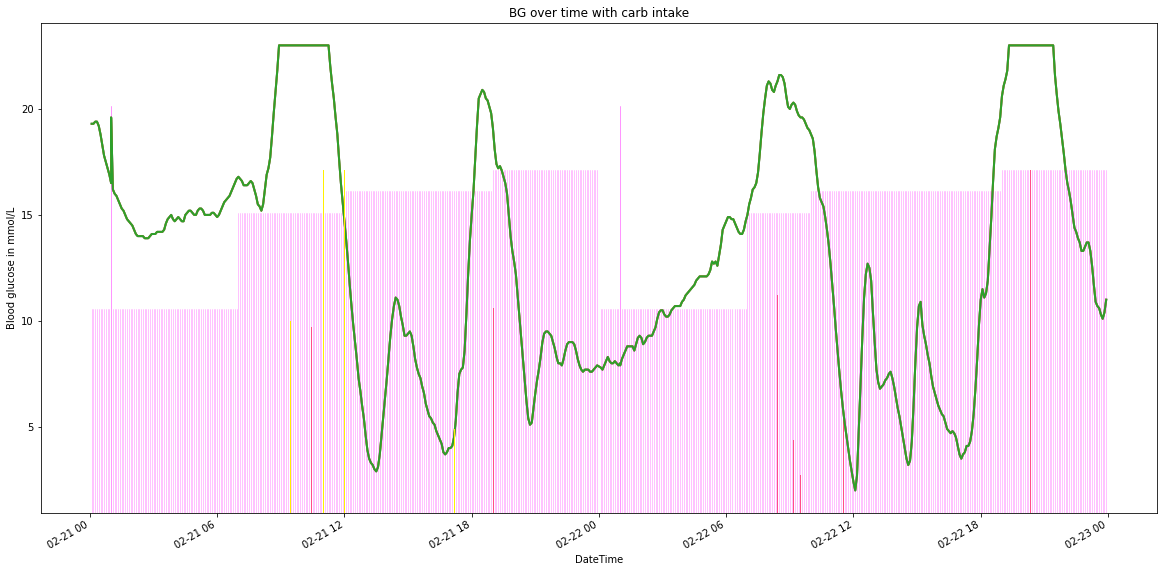

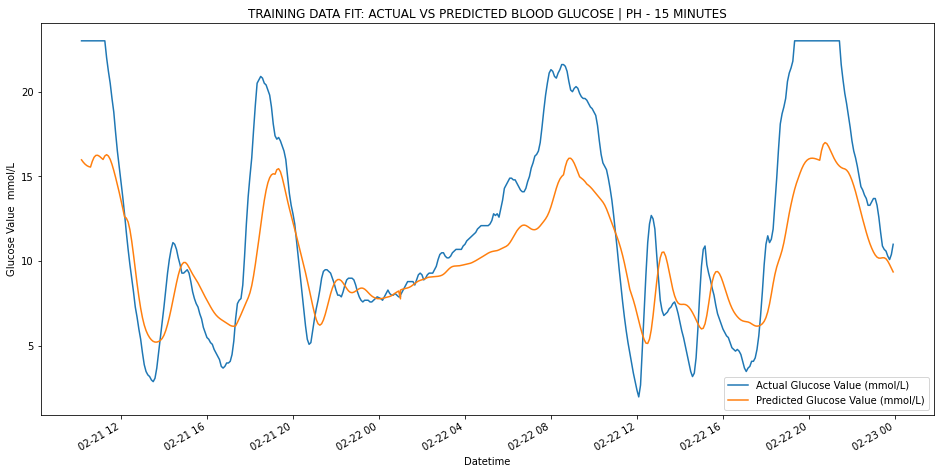

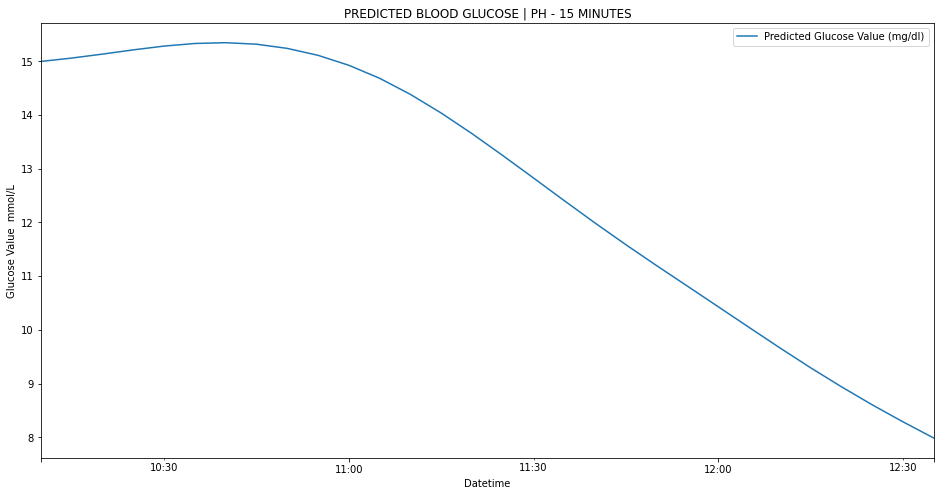

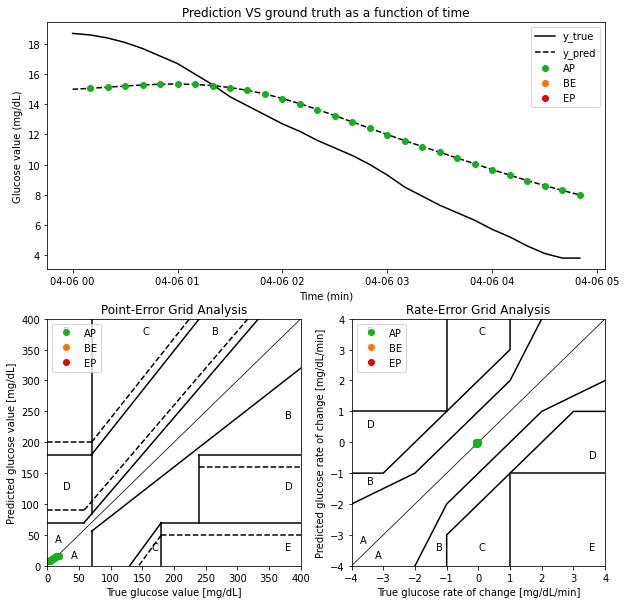

TEST DATA CG-EGA - AP: 1.0 | BE: 0.0 | EP: 0.0
Accurate Predictions: 100.0% 
Benign Errors: 0.0% 
Critical Error Predictions: 0.0%
2016 rows in training data
Index(['bg', 'basal', 'bolus', 'carbs'], dtype='object') columns in training data
576 Data points in training data
                       bg     basal  bolus  carbs
DateTime                                         
2019-02-21 01:00:00  19.6  0.079167    0.0      0
2019-02-21 00:05:00  19.3  0.079167    0.0      0
2019-02-21 00:10:00  19.3  0.079167    0.0      0
2019-02-21 00:15:00  19.4  0.079167    0.0      0
2019-02-21 00:20:00  19.4  0.079167    0.0      0
...                   ...       ...    ...    ...
2019-02-22 23:35:00  10.6  0.133333    0.0      0
2019-02-22 23:40:00  10.3  0.133333    0.0      0
2019-02-22 23:45:00  10.1  0.133333    0.0      0
2019-02-22 23:50:00  10.4  0.133333    0.0      0
2019-02-22 23:55:00  11.0  0.133333    0.0      0

[576 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2016 rows in test data
Index(['bg', 'basal', 'bolus', 'carbs'], dtype='object') columns in test data
288 Data points in test data
                       bg     basal  bolus  carbs
DateTime                                         
2019-02-23 01:00:00  11.6  0.079167    0.0      0
2019-02-23 00:05:00  12.0  0.079167    0.0      0
2019-02-23 00:10:00  12.1  0.079167    1.6      0
2019-02-23 00:15:00  11.8  0.079167    0.0      0
2019-02-23 00:20:00  11.6  0.079167    0.0      0
...                   ...       ...    ...    ...
2019-02-23 23:35:00   7.5  0.133333    0.0      0
2019-02-23 23:40:00   7.5  0.133333    0.0      0
2019-02-23 23:45:00   7.3  0.133333    0.0      0
2019-02-23 23:50:00   7.1  0.133333    0.0      0
2019-02-23 23:55:00   6.8  0.133333    0.0      0

[288 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2019-02-23 01:00:00 to 2019-02-23 23:55:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  -----

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RMSE: 3.09 mg/dl (0.17 mmol/L )
fatal: destination path 'CG-EGA' already exists and is not an empty directory.
mv: cannot move 'CG-EGA' to 'cg_ega/CG-EGA': Directory not empty
AP, BE, EP: (1.0, 0.0, 0.0)


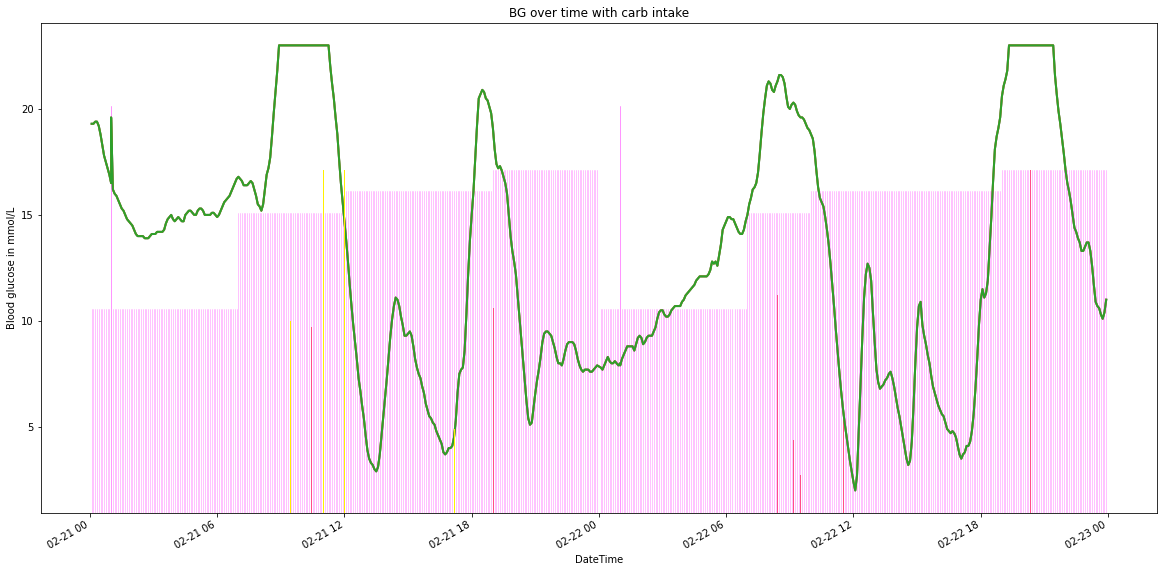

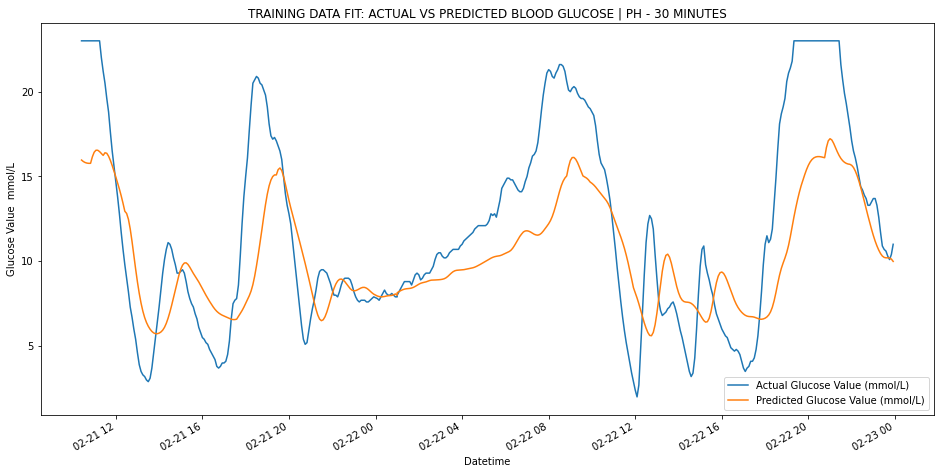

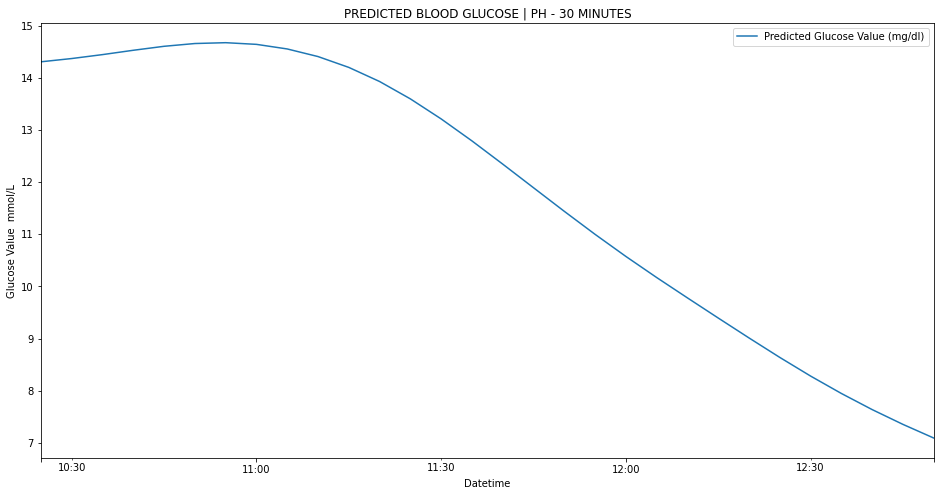

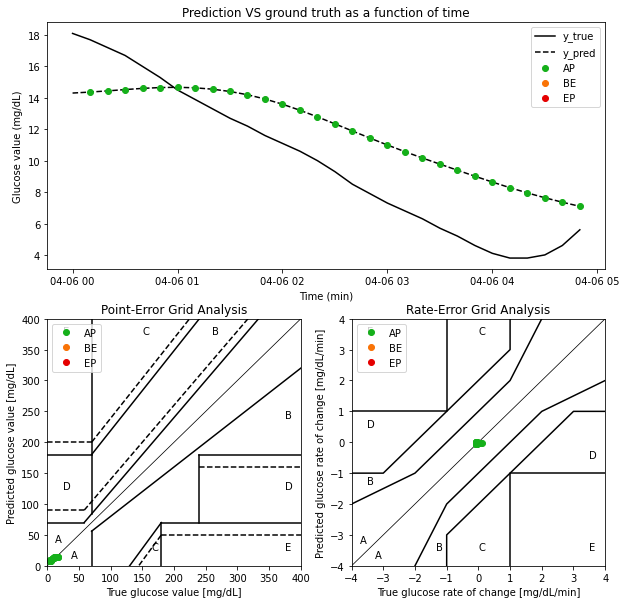

TEST DATA CG-EGA - AP: 1.0 | BE: 0.0 | EP: 0.0
Accurate Predictions: 100.0% 
Benign Errors: 0.0% 
Critical Error Predictions: 0.0%
data {"user": {"name": "Divitry Palette", "gender": "M"}, "h": [{"unit": "minutes", "time": 5, "rmse": "RMSE: 2.43 mg/dl", "test_prediction_path": "outputs/5-test_data_output.json", "graph_test": "outputs/test1.png", "input_graphs": ["outputs/ipgraph-1-1.png", "outputs/ipgraph-1-2.png", "outputs/ipgraph-1-3.png"], "graph_fit": "outputs/trainfit-1.png"}, {"unit": "minutes", "time": 15, "rmse": "RMSE: 2.96 mg/dl", "test_prediction_path": "outputs/15-test_data_output.json", "graph_test": "outputs/test3.png", "input_graphs": ["outputs/ipgraph-3-1.png", "outputs/ipgraph-3-2.png", "outputs/ipgraph-3-3.png"], "graph_fit": "outputs/trainfit-3.png"}, {"unit": "minutes", "time": 30, "rmse": "RMSE: 3.09 mg/dl", "test_prediction_path": "outputs/30-test_data_output.json", "graph_test": "outputs/test6.png", "input_graphs": ["outputs/ipgraph-6-1.png", "outputs/ipgraph-6-2

In [39]:
import json
!rm -rf outputs && mkdir outputs
data = {}
pred_data = []
horizons = [1,3,6]

datapoints_map = {
    1: 30,
    3: 40,
    6: 50,
}

for horizon in horizons:
  prediction_horizon = horizon
  run_api()
  # break

data[API_USER] = {
    API_USER_NAME:patient_name,
    API_USER_GENDER:gender
}
data[API_HORIZONS] = pred_data
dfile = open('outputs/data.json','w')
dfile.write(json.dumps(data))
dfile.close()
print('data',json.dumps(data))

## Start API

In [40]:
!ngrok authtoken 26gauguXOpW8vwGXGRMlDknTSs6_4ju5HqANekgG #this is sensitive, so this is a fake authtoken
!git clone https://github.com/paragdhankhart1dm/t1dmwebsite
!mv t1dmwebsite website

     |████████████████████████████████| 745 kB 5.5 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19007 sha256=276588d0f76fc58ff2c92a9040c923f375ce1ef2be1c56c19aa5fc67004bc13b
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  apache2 apache2-bin apache2-data apache2-utils libapache2-mod-php7.2 libapr1
  libaprutil1 libaprutil1-dbd-sqlite3 libaprutil1-ldap liblua5.2-0
  libmagic-mgc libmagic1 php-common php7.2 php7.2-cli php7.2-common
  php7.2-json php7.2-opcache php7.2-readline ssl-cert
Suggested packages:
  www-browser apache2-doc apache2-suexec-pristine | apache2-suexec-custom ufw
  php-pear file openssl-blacklist
The following NEW packages will be installed:
  apache2 apache2-bin apache2-data apache2-utils libapache2-mo

In [41]:
from pyngrok import ngrok
public_url = ngrok.connect(port = 3000)
print(public_url)
!rm -rf website/outputs && cp -r outputs website/
!cd website && php -S localhost:80

NgrokTunnel: "http://59da-35-196-153-199.ngrok.io" -> "http://localhost:80"
PHP 7.2.24-0ubuntu0.18.04.11 Development Server started at Wed Apr  6 10:12:33 2022
Listening on http://localhost:80
Document root is /content/website
Press Ctrl-C to quit.
[Wed Apr  6 10:31:51 2022] 127.0.0.1:60704 [200]: /
[Wed Apr  6 10:31:54 2022] 127.0.0.1:60718 [200]: /
[Wed Apr  6 10:31:56 2022] 127.0.0.1:60742 [200]: /assets/css/main.css
[Wed Apr  6 10:31:57 2022] 127.0.0.1:60746 [200]: /assets/js/script.js
[Wed Apr  6 10:31:58 2022] 127.0.0.1:60750 [200]: /assets/imgs/header1.png
[Wed Apr  6 10:32:03 2022] 127.0.0.1:60770 [200]: /getData.php
[Wed Apr  6 10:32:18 2022] 127.0.0.1:60804 [200]: /index.html
[Wed Apr  6 10:32:19 2022] 127.0.0.1:60806 [200]: /assets/css/main.css
[Wed Apr  6 10:32:20 2022] 127.0.0.1:60810 [200]: /index.html
[Wed Apr  6 10:32:21 2022] 127.0.0.1:60822 [200]: /assets/js/script.js
[Wed Apr  6 10:32:21 2022] 127.0.0.1:60832 [200]: /assets/imgs/header1.png
[Wed Apr  6 10:32:22 2022]